optunaでtuningしたlgbmsをRFでensemble

In [13]:
import seaborn as sns
import csv
import optuna
import itertools, logging, joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
NOTE_NAME = "lgbm2"

In [6]:
ROUND = "238"
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"
N_FEATURE = 310
N_MODEL = 8

In [37]:
# signal
signals = pd.read_csv(f"{NOTE_NAME}/lgbm2_signals_train.csv", index_col=["id"])
val_signals = pd.read_csv(f"{NOTE_NAME}/lgbm2_signals_val.csv", index_col=["id"])

/home/tarai/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


--- 
### Fit RFReg


In [8]:
# set logger
logger = logging.getLogger()  # root logger
fh = logging.FileHandler(f'{NOTE_NAME}/train3.log')
fh.setFormatter(logging.Formatter('%(asctime)s|%(message)s', '%Y-%m-%d %H:%M:%S'))
logger.addHandler(fh)

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

In [17]:
# test/train split
cols_feature = [str(i) for i in range(N_MODEL)]
_train, _val = train_test_split(signals.loc[:, cols_feature+[TARGET_NAME]], train_size=0.9, random_state=1)

In [18]:
# train signal data
cols_feature = [str(i) for i in range(N_MODEL)]
_train, _val = train_test_split(signals.loc[:, cols_feature+[TARGET_NAME]])
X_train, y_train = _train.loc[:, cols_feature], _train[TARGET_NAME]
X_val, y_val = _val.loc[:, cols_feature], _val[TARGET_NAME]

In [19]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 29, 2)
    min_samples_leaf = trial.suggest_uniform("min_samples_leaf", 0.01, 0.50)
    reg = RandomForestRegressor(
        criterion="mse",
        max_features=None,
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

In [22]:
study.best_params

{'max_depth': 23, 'min_samples_leaf': 0.010028285494760753}

In [35]:
reg = RandomForestRegressor(
    criterion="mse",
    max_features=None,
    max_depth=study.best_params["max_depth"], 
    min_samples_leaf=study.best_params["min_samples_leaf"])
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=23, max_features=None,
                      min_samples_leaf=0.010028285494760753)

In [36]:
joblib.dump(reg, f"{NOTE_NAMETE_NAMETE_NAME}/RFReg.pkl")

['lgbm2/RFReg.pkl']

In [39]:
signals2 = pd.DataFrame(reg.predict(signals.iloc[:, :N_MODEL]), index=signals.index,
                        columns=["pred"]).join(signals[["era", "target"]])

In [38]:
val_signals2 = pd.DataFrame(reg.predict(val_signals.iloc[:, :N_MODEL]), index=val_signals.index,
                            columns=["pred"]).join(val_signals[["era", "target"]])

In [40]:
signals2.head(1)

,pred,era,target
id,,,
n000315175b67977,0.487527,era1,0.5


---
### Eval

#### CORR

In [42]:
# Submissions are scored by spearman correlation
def calcRankCorr(i):
    def _main(df):
        ranked_preds = df[i].rank(pct=True, method="first")
        return np.corrcoef(ranked_preds, df[TARGET_NAME])[0, 1]
    return _main

In [43]:
# era毎にcorr計算
corr = signals2.groupby("era").apply(calcRankCorr("pred"))
val_corr = val_signals2.groupby("era").apply(calcRankCorr("pred"))

In [44]:
# in sample score
corr.agg(["mean", "std", lambda x: x.mean()/x.std()]).to_frame()

,0
mean,0.152671
std,0.024312
<lambda>,6.279708


In [45]:
# validation sample score
val_corr.agg(["mean", "std", lambda x: x.mean()/x.std()]).to_frame()

,0
mean,0.017970
std,0.019971
<lambda>,0.899785


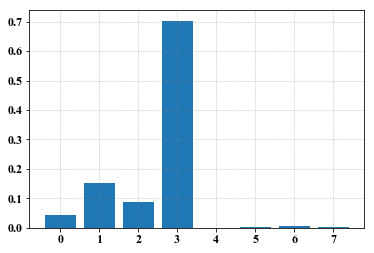

In [49]:
plt.bar(np.arange(reg.feature_importances_.shape[0]), reg.feature_importances_);

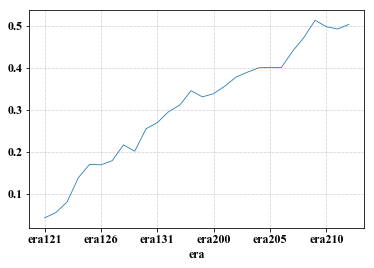

In [53]:
val_corr.cumsum().plot();

In [54]:
val_signals2

,pred,era,target
id,,,
n0003aa52cab36c2,0.509689,era121,0.25
n000920ed083903f,0.489394,era121,0.50
n0038e640522c4a6,0.549561,era121,1.00
n004ac94a87dc54b,0.553053,era121,0.50
n0052fe97ea0c05f,0.507718,era121,0.75
...,...,...,...
nffa978d27d95877,0.509415,eraX,NaN
nffc0ac8f014eee1,0.512449,eraX,NaN
nffc3d2a31602573,0.503524,eraX,NaN


---
#### Submit

In [69]:
import numerapi
sys.path.append("../../"); import auth_info

In [59]:
# tournament_index = \
#     pd.read_csv(f"../../dataset/numerai_dataset_{ROUND}/numerai_tournament_data.csv", usecols=["id", "era", "data_type"], index_col=["id"])

In [80]:
submission_csv = val_signals2.pred.to_frame(PREDICTION_NAME)

In [81]:
submission_csv.head(1)

,prediction
id,
n0003aa52cab36c2,0.509689


In [82]:
submission_csv.to_csv(f"{NOTE_NAME}/submission_rf.csv")

In [83]:
# upload predictions
napi = numerapi.NumerAPI(auth_info.PUBLIC_KEY, auth_info.PRIVATE_KEY)
model_id = napi.get_models()['at496']
napi.upload_predictions(f"{NOTE_NAME}/submission_rf.csv", model_id=model_id)

# check submission status
napi.submission_status(model_id)

{'concordance': None,
 'consistency': None,
 'corrWithExamplePreds': 0.6826662184315225,
 'filename': 'submission_rf-GnQVAcZ7vJKX.csv',
 'validationCorrelation': 0.017969519462009333,
 'validationFeatureExposure': None,
 'validationSharpe': 0.9162959970363684}

In [87]:
napi.get_models()

{'at496': '547a5163-3d5c-41b1-a823-4e52fec993c7'}